IMPORT

In [74]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import ccxt
import json
import os

API BINANCE

In [75]:
#Facultatif

binance = ccxt.binance({
        "apiKey": "YOUR API KEY",
        "secret": "YOUR API SECRET",
    })

DATA 

In [76]:
output_file = '/Users/maxim/OneDrive/Documents/Python/Backtest/crypto_data' + '/eth_usdt_data_1m.csv'

In [77]:
data = pd.read_csv(output_file ,parse_dates=['timestamp']).sort_index(ascending=False)
data

,timestamp,open,high,low,close,volume
2850999,1686306420000,1843.76,1843.77,1843.40,1843.40,52.68750
2850998,1686306360000,1844.20,1844.20,1843.73,1843.77,108.38410
2850997,1686306300000,1844.31,1844.32,1844.19,1844.19,72.12750
2850996,1686306240000,1844.32,1844.32,1844.31,1844.32,19.90100
2850995,1686306180000,1844.23,1844.32,1844.22,1844.31,26.64890
...,...,...,...,...,...,...
4,1514761440000,734.51,735.00,733.56,733.56,4.41220
3,1514761380000,735.06,735.40,733.70,735.00,8.62700
2,1514761320000,735.01,735.55,735.00,735.00,12.41270
1,1514761260000,735.55,735.56,734.99,735.01,1.44695


In [78]:
df = data
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2851000 entries, 2850999 to 0
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), object(1)
memory usage: 152.3+ MB
None
(2851000, 6)


In [79]:
# Conversion de la colonne de timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms') #.dt.strftime('%Y-%m-%d')
df.sort_values('timestamp', inplace=True)

In [80]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2851000 entries, 0 to 2850999
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   open       float64       
 2   high       float64       
 3   low        float64       
 4   close      float64       
 5   volume     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 152.3 MB
None
(2851000, 6)


In [81]:
#fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                                    #open=df['open'],
                                    #high=df['high'],
                                    #low=df['low'],
                                    #close=df['close'])
                     #],
                #layout = go.Layout(
                                    #autosize=False,
                                    #width=1000,
                                    #height=1000)

               #)
#fig.add_trace(go.Line(x=df['Date'],y=df['Open'],))
#fig.show()

## GRID BOT

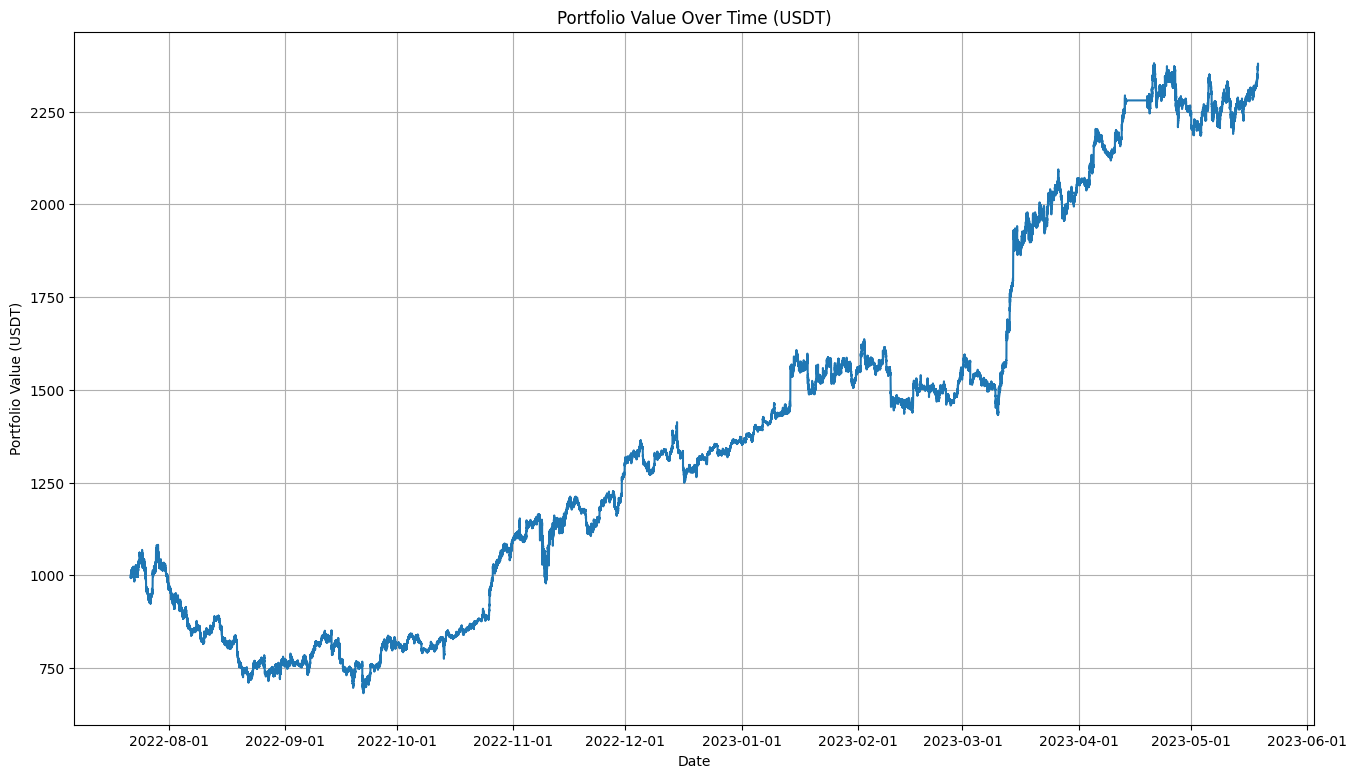

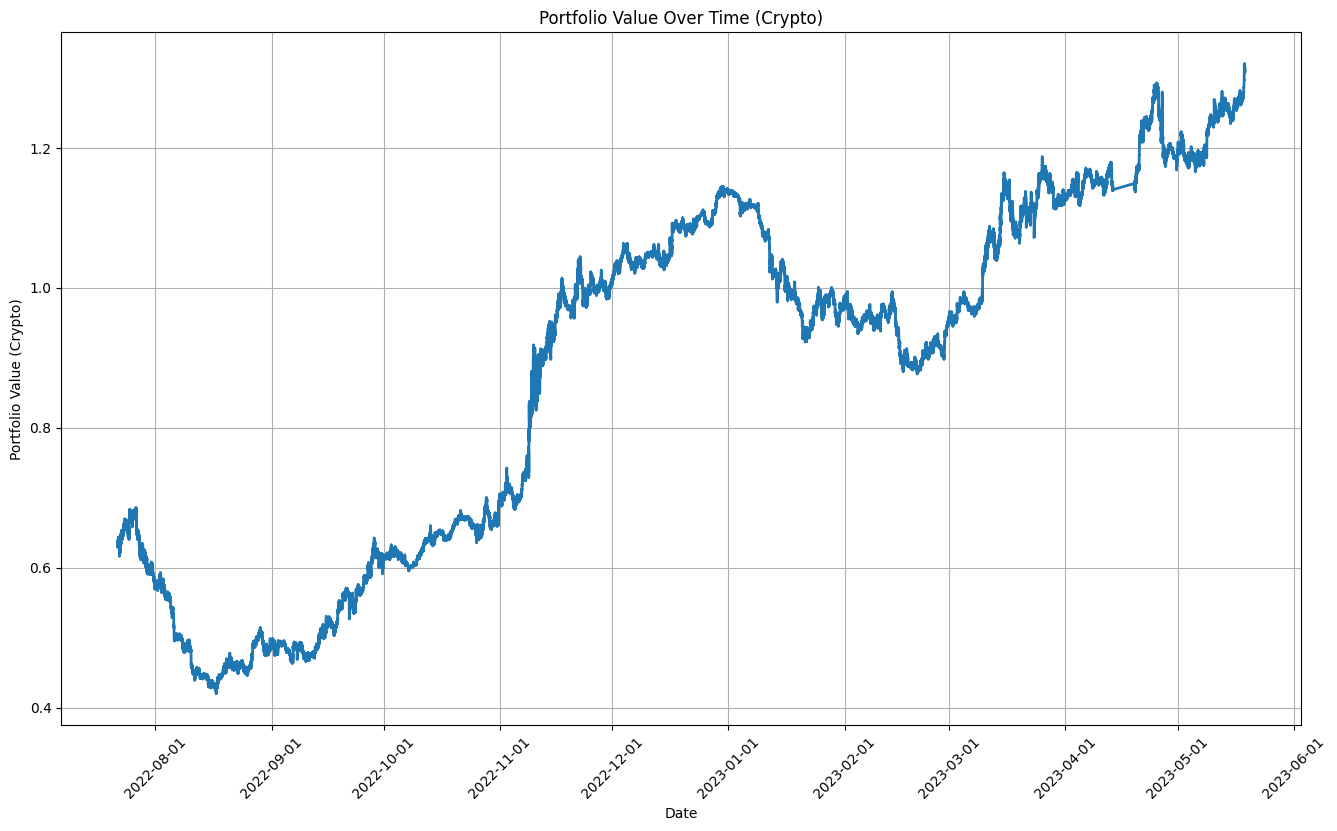

quantité de Crypto au départ 0.29852985242549906
quantité d USDT au départ 529.9647473560517
quantité de Crypto BAH 0.6351222610352493
quantité de USDT BAH 1143.7345188948873
PNL du BAH 1.1437345188948873
dernière valeur du wallet 2374.9987284871163
PNL du wallet 2.374998728487116


In [82]:
class GridBotBacktest:
    def __init__(self, grid_size, drop_threshold, rise_threshold, start_date, end_date, initial_USDT_balance, initial_BTC_balance, trading_range_min, trading_range_max):
        self.grid_size = grid_size
        self.drop_threshold = drop_threshold
        self.rise_threshold = rise_threshold
        self.start_date = start_date
        self.end_date = end_date
        self.initial_USDT_balance = initial_USDT_balance
        self.initial_BTC_balance = initial_BTC_balance
        self.trading_range_min = trading_range_min
        self.trading_range_max = trading_range_max
        self.exchange = ccxt.binance()
        self.exchange.load_markets()
        self.data = df
        self.trades = []
        self.portfolio_value_USDT = []
        self.portfolio_value_BTC = []

    def fetch_historical_data(self):
        # Convertir la valeur de timestamp en type datetime64[ns]
        start_date1 = pd.to_datetime(self.start_date, unit='ms')
        end_date1 = pd.to_datetime(self.end_date, unit='ms')
        self.data = self.data[(self.data['timestamp'] >= start_date1) & (self.data['timestamp'] <= end_date1)]
    def simulate_trading(self):
        USDT_balance = self.initial_USDT_balance
        BTC_balance = self.initial_BTC_balance
        price_range = self.trading_range_max - self.trading_range_min
        num_buy_orders = int(price_range / (self.grid_size * self.trading_range_max))
        num_sell_orders = int(price_range / (self.grid_size * self.trading_range_max))

        for _, row in self.data.iterrows():
            current_price = row['close']
            if self.trading_range_min <= current_price <= self.trading_range_max:
                usdt_allocation = (current_price - self.trading_range_min) / price_range
                btc_allocation = USDT_balance - usdt_allocation

                num_buy_orders = max(int(price_range / (self.grid_size * self.trading_range_max)), 1)
                num_sell_orders = max(int(price_range / (self.grid_size * self.trading_range_min)), 1)
                # Calcul de la taille des ordres d'achat et de vente
                buy_order_size = USDT_balance / num_buy_orders
                sell_order_size = BTC_balance / num_sell_orders

                buy_price_threshold = self.trading_range_min + (self.trading_range_max - self.trading_range_min) * usdt_allocation
                sell_price_threshold = self.trading_range_min + (self.trading_range_max - self.trading_range_min) * btc_allocation

                if current_price <= buy_price_threshold and num_sell_orders > 0 and BTC_balance >= sell_order_size:
                    # Acheter du BTC
                    btc_quantity = buy_order_size / current_price
                    BTC_balance += btc_quantity
                    USDT_balance -= buy_order_size
                    self.trades.append({'timestamp': row['timestamp'], 'price': current_price, 'quantity': btc_quantity, 'type': 'buy'})

                if current_price >= sell_price_threshold and num_sell_orders > 0 and BTC_balance >= sell_order_size:
                    # Vendre du BTC
                    btc_quantity = sell_order_size
                    USDT_balance += btc_quantity * current_price
                    BTC_balance -= sell_order_size
                    self.trades.append({'timestamp': row['timestamp'], 'price': current_price, 'quantity': btc_quantity, 'type': 'sell'})
            self.portfolio_value_USDT.append(USDT_balance)
            self.portfolio_value_BTC.append(BTC_balance)


    def run_backtest(self):
        self.fetch_historical_data()
        self.simulate_trading()
        portfolio_value_USDT_df = pd.DataFrame({'timestamp': self.data['timestamp'], 'value': self.portfolio_value_USDT})
        portfolio_value_BTC_df = pd.DataFrame({'timestamp': self.data['timestamp'], 'value': self.portfolio_value_BTC})
        return pd.DataFrame(self.trades), portfolio_value_USDT_df, portfolio_value_BTC_df

# Exemple d'utilisation du Grid Bot Backtest
grid_size = 100
trading_range_max = 2000
trading_range_min = 1000
drop_threshold = (trading_range_max - trading_range_min)/grid_size
rise_threshold = drop_threshold

#Conversion des dates en ms
start_date1 = '2022-07-22'
date_obj = datetime.strptime(start_date1, '%Y-%m-%d')
timestamp1 = date_obj.timestamp() * 1000

timestamp_str = str(int(timestamp1))  # Convertir le timestamp en chaîne de caractères

end_date1 = '2023-05-19'
date_obj = datetime.strptime(end_date1, '%Y-%m-%d')
timestamp2 = date_obj.timestamp() * 1000

timestamp_str = str(int(timestamp2))  # Convertir le timestamp en chaîne de caractères
selected_close = data.loc[data['timestamp'] == start_date1, 'close'].values[0]
end_close = data.loc[data['timestamp'] == end_date1, 'close'].values[0]


initial_USDT_balance = 1000
buy_and_hold = initial_USDT_balance / selected_close
buy_and_hold_f = buy_and_hold * end_close
PNL =  buy_and_hold_f/ initial_USDT_balance

qty_btc = (initial_USDT_balance / ((((trading_range_max - selected_close) * 0.005) / grid_size) * 100)) / selected_close
qty_USDT = initial_USDT_balance - (initial_USDT_balance / ((((trading_range_max - selected_close) * 0.005) / grid_size) * 100))
backtest = GridBotBacktest(grid_size = grid_size,drop_threshold=drop_threshold, rise_threshold=rise_threshold, start_date = timestamp1, end_date = timestamp2, initial_BTC_balance=0,  initial_USDT_balance = 1000, trading_range_min = trading_range_min , trading_range_max = trading_range_max)
trades_df, portfolio_value_USDT_df, portfolio_value_BTC_df = backtest.run_backtest()

# Conversion du portefeuille en BTC en valeur équivalente en USDT
btc_prices = backtest.data['close']
#portfolio_value_USDT_df['value'] = portfolio_value_BTC_df['value'] * btc_prices


# Graphique de l'évolution de la valeur du portefeuille
fig, ax = plt.subplots(figsize=(16,9))

de = portfolio_value_USDT_df[portfolio_value_USDT_df.value>0]
ax.plot_date(de['timestamp'], de['value'], '-')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (USDT)')
ax.set_title('Portfolio Value Over Time (USDT)')
#ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid(True)
plt.ylim()
plt.show()



# Graphique de l'évolution de la valeur du portefeuille en BTC
fig, ax = plt.subplots(figsize=(16,9))
df = portfolio_value_BTC_df[portfolio_value_BTC_df.value>0]
ax.plot(df['timestamp'], df['value'], linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value (Crypto)')
ax.set_title('Portfolio Value Over Time (Crypto)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.grid(True)
plt.ylim()
plt.xticks(rotation=45)
plt.show()

last_portfolio_value = portfolio_value_USDT_df['value'].iloc[-1]  # Récupère la dernière valeur du portefeuille']
PNL_wallet = last_portfolio_value/initial_USDT_balance
print('quantité de Crypto au départ' , qty_btc)
print('quantité d USDT au départ', qty_USDT)
print('quantité de Crypto BAH' , buy_and_hold)
print('quantité de USDT BAH' , buy_and_hold_f)
print('PNL du BAH' , PNL)
print('dernière valeur du wallet' , last_portfolio_value)
print('PNL du wallet' , PNL_wallet)


In [83]:
portfolio_value_BTC_df.agg({'timestamp':['min','max']})

,timestamp
min,2022-07-21 22:00:00
max,2023-05-18 22:00:00
